# Análisis de Texto

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Importar librerias

In [ ]:
import openpyxl
import pandas as pd
import numpy as np
import nltk
import glob
import re
import urllib
import requests
import os
import wget
import time
from collections import defaultdict
from sklearn import preprocessing
from bs4 import BeautifulSoup
from urllib.request import urlopen
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

### Cargar archivo csv

In [ ]:
pines = pd.read_csv("pins_20220306.csv")

In [ ]:
pines.rename(columns={'pin_id':'id','comment':'comentarios','created_at':'creado','domain':'dominio'}, inplace=True)

In [ ]:
pines.shape

(305740, 15)

#### Transformar a NaN espacios en blanco en columna [comentarios]

In [ ]:
pines["comentarios"] = pines["comentarios"].replace(' ', np.nan, inplace=False)

In [ ]:
pines.shape

(305740, 15)

#### Eliminar todas las filas con valor NaN en columna [comentarios]

In [ ]:
pines = pines.dropna(axis=0, subset=["comentarios"])

In [ ]:
pines.head(3)

,Unnamed: 0,Unnamed: 0.1,id,userId,userName,dominio,img_Url,comentarios,title,creado,follower_count,locale,reaction_counts,repin_count,Unnamed: 0.1.1
4,4,4,411305378457667982,1.071014e+17,oyshostore,oysho.com,https://i.pinimg.com/originals/e8/96/1d/e8961d...,Orchid flower nightdress - New In - LINGERIE |...,Orchid flower nightdress - New In - LINGERIE |...,"Fri, 21 Apr 2017 05:08:25 +0000",58163,es-ES,{},0,NaN
5,5,5,737534876445681460,1.071014e+17,oyshostore,oysho.com,https://i.pinimg.com/originals/9f/3f/94/9f3f94...,Grey striped rabbit top - New In - Autumn Wint...,Grey striped rabbit top - New In - NIGHTWEAR |...,"Sat, 01 Oct 2016 09:58:22 +0000",58163,es-ES,{},0,NaN
6,6,6,250372060513819486,1.071014e+17,oyshostore,oysho.com,https://i.pinimg.com/originals/4f/cd/28/4fcd28...,Jersey stripe trousers - New In - Autumn Winte...,Jersey stripe trousers - New In - ACTIVEWEAR |...,"Wed, 19 Oct 2016 07:53:38 +0000",58163,es-ES,{},0,NaN


In [ ]:
pines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204700 entries, 4 to 305738
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       204700 non-null  int64  
 1   Unnamed: 0.1     204700 non-null  int64  
 2   id               204700 non-null  object 
 3   userId           204700 non-null  float64
 4   userName         196852 non-null  object 
 5   dominio          204700 non-null  object 
 6   img_Url          204700 non-null  object 
 7   comentarios      204700 non-null  object 
 8   title            191416 non-null  object 
 9   creado           204700 non-null  object 
 10  follower_count   204700 non-null  int64  
 11  locale           173418 non-null  object 
 12  reaction_counts  204700 non-null  object 
 13  repin_count      204700 non-null  int64  
 14  Unnamed: 0.1.1   102350 non-null  float64
dtypes: float64(2), int64(4), object(9)
memory usage: 25.0+ MB


In [ ]:
pines.shape

(204700, 15)

### Delimitar temporada y el rango de años en columna [creado]

In [ ]:
pines.creado

4         Fri, 21 Apr 2017 05:08:25 +0000
5         Sat, 01 Oct 2016 09:58:22 +0000
6         Wed, 19 Oct 2016 07:53:38 +0000
7         Tue, 20 Dec 2016 20:32:55 +0000
8         Wed, 30 Nov 2016 15:35:19 +0000
                       ...               
305731    Wed, 10 Nov 2021 08:09:12 +0000
305733    Mon, 27 Sep 2021 04:24:10 +0000
305735    Thu, 23 Sep 2021 05:43:16 +0000
305736    Mon, 27 Sep 2021 04:23:43 +0000
305738    Mon, 27 Sep 2021 04:08:21 +0000
Name: creado, Length: 204700, dtype: object

In [ ]:
pines["creado"] = [i[5:-15] for i in pines.creado]

In [ ]:
pines['creado'] = pd.to_datetime(pines['creado'])


##### Ordenar por año en ascendencia

In [ ]:
pines = pines.sort_values(by=["creado"],ascending=True)

In [ ]:
pines.head()

,Unnamed: 0,Unnamed: 0.1,id,userId,userName,dominio,img_Url,comentarios,title,creado,follower_count,locale,reaction_counts,repin_count,Unnamed: 0.1.1
115964,3090,3090,46795283597629927,1.719814e+17,metmuseum,metmuseum.org,https://i.pinimg.com/originals/7e/2d/8d/7e2d8d...,love the lines on this swimming suit,Rudi Gernreich | Bikini | American | The Metro...,2010-11-18,887277,en-US,{},2,NaN
268834,115964,3090,46795283597629927,1.719814e+17,metmuseum,metmuseum.org,https://i.pinimg.com/originals/7e/2d/8d/7e2d8d...,love the lines on this swimming suit,Rudi Gernreich | Bikini | American | The Metro...,2010-11-18,887277,en-US,{},2,3090.0
165656,12786,2786,211174952011305,2.113124e+14,https://www.pinterest.com/duchampian/,Uploaded by user,https://i.pinimg.com/originals/79/6d/07/796d07...,new bathing suit. just had to have it. wish it...,NaN,2011-03-24,0,NaN,{},0,2786.0
12786,2786,2786,211174952011305,2.113124e+14,https://www.pinterest.com/duchampian/,Uploaded by user,https://i.pinimg.com/originals/79/6d/07/796d07...,new bathing suit. just had to have it. wish it...,NaN,2011-03-24,0,NaN,{},0,NaN
33082,3082,3082,37858453087064062,3.785859e+16,https://www.pinterest.com/iforgotyourface/,glamoursplash.com,https://i.pinimg.com/originals/8d/21/f7/8d21f7...,THESE COLORS. THAT BACK HARNESS.,As seen from the back - Vintage Swimwear 1961,2011-05-17,0,NaN,{},1,NaN


#### Rango (2015 - 2020) entre meses (Marzo - Septiembre) cada año

In [ ]:
pines_filtrados = pines[pines["creado"].isin(pd.date_range('2016-03-01', '2020-09-30'))]

In [ ]:
pines_filtrados = pines_filtrados[(pines_filtrados['creado'].dt.strftime('%m') >= '03') & (pines['creado'].dt.strftime('%m') <= '09')]


/Users/JuanLeyva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


##### Detectar si hay comentarios en meses posteriores a Septiembre

In [ ]:
pines_filtrados[pines_filtrados['creado'].dt.strftime('%m') > '09']


,Unnamed: 0,Unnamed: 0.1,id,userId,userName,dominio,img_Url,comentarios,title,creado,follower_count,locale,reaction_counts,repin_count,Unnamed: 0.1.1


In [ ]:
pines_filtrados.shape

(70388, 15)

### Función limpieza & conversion a Tokens

In [ ]:
def unigram_tokens(comentarios):
    # Se convierte todo el texto a minúsculas
    comentario = comentarios.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    comentario = re.sub('http\S+', ' ', comentario)
    # Eliminación de hipervinculos
    comentario = re.sub('href\S+', ' ', comentario)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\]\\^_\\`\\{\\|\\}\\~]'
    comentario = re.sub(regex , ' ', comentario)
    # Eliminación de espacios en blanco múltiples
    comentario = re.sub("\\s+", ' ', comentario)
    # Tokenización por palabras individuales
    comentario = comentario.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    comentario = [token for token in comentario if len(token) > 1]
    # Eliminacion de las StopWords
    stop_words = set(stopwords.words('english'))
    comentario = [w for w in comentario if not w.lower() in stop_words]

    return(comentario)

## N-grams

#### Unigram

##### Tokenizacion por comentario

In [ ]:
pines_filtrados['unigram_tokens'] = pines_filtrados['comentarios'].apply(lambda x: unigram_tokens(x))
pines_filtrados[['comentarios', 'unigram_tokens']].head()

,comentarios,unigram_tokens
626,Seea Adria Bikini Top,"[seea, adria, bikini, top]"
186566,Out From Under Carolina Maxi Slip,"[carolina, maxi, slip]"
158268,Dsquared2 - Spring 2016 RTW - The Cut,"[dsquared2, spring, 2016, rtw, cut]"
66158,Monokini crochet,"[monokini, crochet]"
221445,Anthropologie,[anthropologie]


#### Bigrams

##### Tokenizacion por comentario

In [ ]:
pines_filtrados['bigram_tokens'] = pines_filtrados['unigram_tokens'].apply(lambda x: list(ngrams(x,2)))

In [ ]:
pines_filtrados['bigram_tokens'] = pines_filtrados['bigram_tokens'].apply(lambda x: [*map(' '.join,x)])

In [ ]:
pines_filtrados['unigram_tokens'].head()

626                [seea, adria, bikini, top]
186566                 [carolina, maxi, slip]
158268    [dsquared2, spring, 2016, rtw, cut]
66158                     [monokini, crochet]
221445                        [anthropologie]
Name: unigram_tokens, dtype: object

In [ ]:
pines_filtrados['bigram_tokens'].head()

626                  [seea adria, adria bikini, bikini top]
186566                           [carolina maxi, maxi slip]
158268    [dsquared2 spring, spring 2016, 2016 rtw, rtw ...
66158                                    [monokini crochet]
221445                                                   []
Name: bigram_tokens, dtype: object

### Leer archivo xlsx - archivo(Catart)

In [ ]:
cat = pd.read_excel("Catart_2.xlsx")

#### Preprocesamiento y limpieza - archivo(Catart)

##### Guardar cada atributo en una variable

In [ ]:
color = cat.COLOR
estilo = cat.ESTILO
tela = cat.DESCCOMPOSICION

##### Eliminar valores NaN

In [ ]:
color = color.dropna()
estilo = estilo.dropna()
tela = tela.dropna()

##### Convertir todos los elementos en minusculas

In [ ]:
color = color.str.lower()
estilo = estilo.str.lower()
tela = tela.str.lower()

##### Eliminar elementos duplicados

In [ ]:
color = color.drop_duplicates()
estilo = estilo.drop_duplicates()
tela = tela.drop_duplicates()

##### Seleccionar solo los elementos de estilo

In [ ]:
#estilo = [i[3:] for i in estilo]


##### Convertir en lista cada atributo

In [ ]:
estilo = list(dict.fromkeys(estilo))

In [ ]:
tela = list(dict.fromkeys(tela))

In [ ]:
color = list(dict.fromkeys(color))

### Archivo xlsx de atributos

##### Convertir atributos en Dataframe

In [ ]:
dt_c = pd.DataFrame(color).reset_index()
dt_t = pd.DataFrame(tela).reset_index()
dt_e = pd.DataFrame(estilo).reset_index()

##### Renombrar columnas en Dataframe

In [ ]:
dt_c.rename(columns = {0 : "index", 1: "color"},inplace=True)
dt_t.rename(columns = {0 : "index", 1: "tela"},inplace=True)
dt_e.rename(columns = {0 : "index", 1: "estilo"},inplace=True)

##### Eliminar columna de indice

In [ ]:
dt_c = dt_c.drop(columns=["index"])
dt_t = dt_t.drop(columns=["index"])
dt_e = dt_e.drop(columns=["index"])


##### Concatenar atributos en un solo Dataframe

In [ ]:
atributos = pd.concat([dt_c, dt_t, dt_e], axis=1)

In [ ]:
atributos.head()

""
0
1
2
3
4


##### Exportar Dataframe de atributos a archivo de excel

In [ ]:
atributos.to_excel("atributos.xlsx",index=False)

## Nested List Comprehensions

#### Detectar atributos (color, tela y estilo) por comentario - (Datos entrenamiento)

In [ ]:
pines_filtrados['bigram_tokens']

626                  [seea adria, adria bikini, bikini top]
186566                           [carolina maxi, maxi slip]
158268    [dsquared2 spring, spring 2016, 2016 rtw, rtw ...
66158                                    [monokini crochet]
221445                                                   []
                                ...                        
121905    [new acacia, acacia orchid, orchid crochet, cr...
160932    [shop fast, fast growing, growing online, onli...
107040    [33 white, white jumpsuits, jumpsuits weddings...
137678    [first shop, shop new, new arrivals, arrivals ...
276779    [whether you’re, you’re planning, planning nex...
Name: bigram_tokens, Length: 70388, dtype: object

In [ ]:
Atributo_C = []
for comentario in pines_filtrados['unigram_tokens']:
    atributo = [token for token in comentario if token in color if token in comentario]
    Atributo_C.append(atributo)


In [ ]:
Atributo_T = []
for comentario in pines_filtrados['unigram_tokens']:
    atributo = [token for token in comentario if token in tela if token in comentario]
    Atributo_T.append(atributo)


In [ ]:
Atributo_E = []
for comentario in pines_filtrados['bigram_tokens']:
    atributo = [elemento for subs in comentario for elemento in estilo if elemento in subs]
    Atributo_E.append(atributo)


##### Convertir atributos en Dataframe

In [ ]:
df_c = pd.DataFrame(Atributo_C)
df_t = pd.DataFrame(Atributo_T)
df_e = pd.DataFrame(Atributo_E)

##### Renombrar columnas en Dataframe

In [ ]:
df_c.rename(columns = {0 : "color_1", 1: "color_2", 2: "color_3"},inplace=True)
df_t.rename(columns = {0 : "tela_1", 1: "tela_2", 2: "tela_3"},inplace=True)
df_e.rename(columns = {0 : "estilo_1", 1: "estilo_2", 2: "estilo_3"},inplace=True)

##### Seleccionar columnas especificas en Dataframe

In [ ]:
df_c = df_c[["color_1", "color_2", "color_3"]]
df_t = df_t[["tela_1", "tela_2", "tela_3"]]
df_e = df_e[["estilo_1", "estilo_2", "estilo_3"]]

### Dataframe con columnas de interes

##### Eliminar columnas sin relevancia

In [ ]:
df = pines_filtrados.drop(columns=["Unnamed: 0","Unnamed: 0.1","img_Url","title","unigram_tokens","bigram_tokens","reaction_counts","locale","Unnamed: 0.1.1"], axis= 1).reset_index()

##### Concatenar Dataframes para un analisis posterior

In [ ]:
df = pd.concat([df, df_c, df_t, df_e], axis=1, ignore_index=True)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,626,313140980321868905,2.598016e+17,urbanoutfitters,urbanoutfitters.com,Seea Adria Bikini Top,2016-03-01,3059122,1,None,None,None,None,None,None,None,None,None
1,186566,70791025371281551,2.598016e+17,urbanoutfitters,urbanoutfitters.com,Out From Under Carolina Maxi Slip,2016-03-01,3059125,0,None,None,None,None,None,None,None,None,None
2,158268,465700417698566187,4.517694e+16,nymag,nymag.com,Dsquared2 - Spring 2016 RTW - The Cut,2016-03-01,180274,0,None,None,None,None,None,None,None,None,None
3,66158,407857309985061022,3.269334e+17,weloveboho,weloveboho.com,Monokini crochet,2016-03-01,201442,0,None,None,None,None,None,None,None,None,None
4,221445,307511480788033140,2.427742e+16,anthropologie,anthropologie.com,Anthropologie,2016-03-01,1605335,0,None,None,None,None,None,None,None,None,None


##### Renombrar columnas del Dataframe

In [ ]:
df = df.rename(columns={0:"index",1:"id",2:"usuario_id",3:"usuario",4:"dominio",5:"comentarios",6:"creado",7:"Num_seguidores",8:"repin_count",9:"atributo_color_1",10:"atributo_color_2",
                        11:"atributo_color_3",12:"atributo_tela_1",13:"atributo_tela_2",14:"atributo_tela_3",15:"atributo_estilo_1",16:"atributo_estilo_2",17:"atributo_estilo_3"})


##### Conversion a string - (columna [usuario_id])

In [ ]:
df['usuario_id'] = df['usuario_id'].apply(lambda x: '{:.0f}'.format(x))
df['usuario_id'] = df['usuario_id'].astype(str)

##### Eliminar pines duplicados

In [ ]:
df = df.drop_duplicates(subset=['id'])

### Dataframe con atributos (max 3 elementos por atributo)

In [ ]:
df_atributos = df[["id","usuario_id","usuario","comentarios","creado","Num_seguidores","repin_count","atributo_color_1","atributo_color_2","atributo_color_3","atributo_tela_1","atributo_tela_2","atributo_tela_3","atributo_estilo_1","atributo_estilo_2","atributo_estilo_3"]]


In [ ]:
df_atributos

,id,usuario_id,usuario,comentarios,creado,Num_seguidores,repin_count,atributo_color_1,atributo_color_2,atributo_color_3,atributo_tela_1,atributo_tela_2,atributo_tela_3,atributo_estilo_1,atributo_estilo_2,atributo_estilo_3,color,tela,estilo
0,129689664247791019,129689801677865344,POPSUGARFitness,"With full coverage and a shelf bra, you'll be ...",2016-03-01,748646,13,0,0,0,0,0,0,one piece,0,0,0,0,0
1,492651646718979160,465559817637892800,DressTrendscom,sport-coat-with-jeans-4,2016-03-01,2781,1,0,0,0,0,0,0,sport,0,0,0,0,0
2,223420831492840339,137289626049056160,target,Women's Push Up Cut-Out Bandeau One Piece - Xh...,2016-03-01,4287730,0,0,0,0,0,0,0,one piece,0,0,0,0,0
3,238339005257824737,238339142688181504,https://www.pinterest.com/acfr1968/,VIX Agatha embroidered voile maxi dress | Cut ...,2016-03-01,0,0,0,0,0,voile,voile,0,0,0,0,0,0,0
4,43558321373797279,43558458804407040,https://www.pinterest.com/madvintage/,Super fun 1970s romper set! Mini romper top/dr...,2016-03-01,0,0,royal,blue,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,690035974151076437,452611968709202240,formalhouse,Ganchillo Bikini Top Beige blanco mujer parte ...,2020-09-29,0,0,beige,blanco,0,0,0,0,0,0,0,0,0,0
14039,842313936552154067,560416884789374464,rockindocks,Material:PolyesterStyle:FashionSleeve Length(c...,2020-09-29,8149,0,0,0,0,polyester,0,0,normal,normal,0,0,0,0
14040,56224695337645650,23432997969621924,theposhmarkapp,New acacia orchid crochet panama bikini top sw...,2020-09-30,683462,0,pink,purple,0,0,0,0,0,0,0,0,0,0
14041,98094098123977732,121104814888194720,seokingz,Sexy V-neck One-piece Swimsuit Women high wais...,2020-09-30,10785,3,black,white,black,0,0,0,one piece,thong,thong,0,0,0


##### Reemplazar los valores "None" de multiples columnas seleccionadas por 0

In [ ]:
df_atributos[["atributo_color_1","atributo_color_2","atributo_color_3","atributo_tela_1","atributo_tela_2","atributo_tela_3","atributo_estilo_1","atributo_estilo_2","atributo_estilo_3"]] = df_atributos[["atributo_color_1","atributo_color_2","atributo_color_3","atributo_tela_1","atributo_tela_2","atributo_tela_3","atributo_estilo_1","atributo_estilo_2","atributo_estilo_3"]].fillna(0)


/Users/JuanLeyva/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


##### Delimitar a solo pines que contengan al menos un atributo (color, tela y estilo) distinto a 0

In [ ]:
df_atributos = df_atributos.loc[(df_atributos.atributo_color_1 != 0) | (df_atributos.atributo_tela_1 != 0) | (df_atributos.atributo_estilo_1 != 0)].reset_index()


##### Etiqueta de atributos (color, tela y estilo)

In [ ]:
df_atributos["color"] = 0
df_atributos["tela"] = 0
df_atributos["estilo"] = 0

##### Eliminar columna [index]

In [ ]:
df_atributos = df_atributos.drop(columns = ["index"])

In [ ]:
df_atributos

,id,usuario_id,usuario,comentarios,creado,Num_seguidores,repin_count,atributo_color_1,atributo_color_2,atributo_color_3,atributo_tela_1,atributo_tela_2,atributo_tela_3,atributo_estilo_1,atributo_estilo_2,atributo_estilo_3,color,tela,estilo
0,129689664247791019,129689801677865344,POPSUGARFitness,"With full coverage and a shelf bra, you'll be ...",2016-03-01,748646,13,0,0,0,0,0,0,one piece,0,0,0,0,0
1,492651646718979160,465559817637892800,DressTrendscom,sport-coat-with-jeans-4,2016-03-01,2781,1,0,0,0,0,0,0,sport,0,0,0,0,0
2,223420831492840339,137289626049056160,target,Women's Push Up Cut-Out Bandeau One Piece - Xh...,2016-03-01,4287730,0,0,0,0,0,0,0,one piece,0,0,0,0,0
3,238339005257824737,238339142688181504,https://www.pinterest.com/acfr1968/,VIX Agatha embroidered voile maxi dress | Cut ...,2016-03-01,0,0,0,0,0,voile,voile,0,0,0,0,0,0,0
4,43558321373797279,43558458804407040,https://www.pinterest.com/madvintage/,Super fun 1970s romper set! Mini romper top/dr...,2016-03-01,0,0,royal,blue,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,690035974151076437,452611968709202240,formalhouse,Ganchillo Bikini Top Beige blanco mujer parte ...,2020-09-29,0,0,beige,blanco,0,0,0,0,0,0,0,0,0,0
14039,842313936552154067,560416884789374464,rockindocks,Material:PolyesterStyle:FashionSleeve Length(c...,2020-09-29,8149,0,0,0,0,polyester,0,0,normal,normal,0,0,0,0
14040,56224695337645650,23432997969621924,theposhmarkapp,New acacia orchid crochet panama bikini top sw...,2020-09-30,683462,0,pink,purple,0,0,0,0,0,0,0,0,0,0
14041,98094098123977732,121104814888194720,seokingz,Sexy V-neck One-piece Swimsuit Women high wais...,2020-09-30,10785,3,black,white,black,0,0,0,one piece,thong,thong,0,0,0


##### Exportar dataframe a archivo csv

In [ ]:
df_atributos.to_csv('df_atributos.csv')

### Dataframe con atributos etiquetados por su valor en diccionario

In [ ]:
df_atributos_tag = df[["id","usuario_id","usuario","creado","Num_seguidores","repin_count","atributo_color_1","atributo_color_2","atributo_color_3","atributo_tela_1","atributo_tela_2","atributo_tela_3","atributo_estilo_1","atributo_estilo_2","atributo_estilo_3"]]


In [ ]:
df_atributos_tag.head()

,id,usuario_id,usuario,creado,Num_seguidores,repin_count,atributo_color_1,atributo_color_2,atributo_color_3,atributo_tela_1,atributo_tela_2,atributo_tela_3,atributo_estilo_1,atributo_estilo_2,atributo_estilo_3
0,313140980321868905,259801609662367008,urbanoutfitters,2016-03-01,3059122,1,None,None,None,None,None,None,None,None,None
1,70791025371281551,259801609662367008,urbanoutfitters,2016-03-01,3059125,0,None,None,None,None,None,None,None,None,None
2,465700417698566187,45176939920493432,nymag,2016-03-01,180274,0,None,None,None,None,None,None,None,None,None
3,407857309985061022,326933391607916864,weloveboho,2016-03-01,201442,0,None,None,None,None,None,None,None,None,None
4,307511480788033140,24277422899724312,anthropologie,2016-03-01,1605335,0,None,None,None,None,None,None,None,None,None


#### Dictionary comprenhension (color)

Insertar valor "None" en lista color

In [ ]:
color.insert(0, None)

In [ ]:
color_dict = {k: v for v, k in enumerate(color)}

Reemplazar elemento de atributo(color) en multiples columnas seleccionadas por su valor en diccionario

In [ ]:
df_atributos_tag = df_atributos_tag.replace({"atributo_color_1":color_dict,"atributo_color_2":color_dict,"atributo_color_3":color_dict})


In [ ]:
df_atributos_tag

,id,usuario_id,usuario,creado,Num_seguidores,repin_count,atributo_color_1,atributo_color_2,atributo_color_3,atributo_tela_1,atributo_tela_2,atributo_tela_3,atributo_estilo_1,atributo_estilo_2,atributo_estilo_3
0,129689664247791019,129689801677865344,POPSUGARFitness,2016-03-01,748646,13,0,0,0,0,0,0,5,0,0
1,492651646718979160,465559817637892800,DressTrendscom,2016-03-01,2781,1,0,0,0,0,0,0,2,0,0
2,223420831492840339,137289626049056160,target,2016-03-01,4287730,0,0,0,0,0,0,0,5,0,0
3,238339005257824737,238339142688181504,https://www.pinterest.com/acfr1968/,2016-03-01,0,0,0,0,0,21,21,0,0,0,0
4,43558321373797279,43558458804407040,https://www.pinterest.com/madvintage/,2016-03-01,0,0,55,12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,690035974151076437,452611968709202240,formalhouse,2020-09-29,0,0,40,28,0,0,0,0,0,0,0
14039,842313936552154067,560416884789374464,rockindocks,2020-09-29,8149,0,0,0,0,3,0,0,9,9,0
14040,56224695337645650,23432997969621924,theposhmarkapp,2020-09-30,683462,0,10,43,0,0,0,0,0,0,0
14041,98094098123977732,121104814888194720,seokingz,2020-09-30,10785,3,4,31,4,0,0,0,5,10,10


#### Dictionary comprehension (tela)

Insertar valor "None" en lista tela

In [ ]:
tela.insert(0, None)

In [ ]:
tela_dict = {k: v for v, k in enumerate(tela)}

Reemplazar elemento de atributo(tela) de multiples columnas seleccionadas por su valor en diccionario

In [ ]:
df_atributos_tag = df_atributos_tag.replace({"atributo_tela_1":tela_dict,"atributo_tela_2":tela_dict,"atributo_tela_3":tela_dict})


#### Dictionary comprehension (estilo)

Insertar valor "None" en lista estilo

In [ ]:
estilo.insert(0, None)

In [ ]:
estilo_dict = {k: v for v, k in enumerate(estilo)}

Reemplazar elemento de atributo(estilo) en multiples columnas seleccionadas por su valor en diccionario

In [ ]:
df_atributos_tag = df_atributos_tag.replace({"atributo_estilo_1":estilo_dict,"atributo_estilo_2":estilo_dict,"atributo_estilo_3":estilo_dict})


#### Dataframe con pines que tienen detectan al menos un atributo - dimension (14043 filas, 15 columnas)

##### Delimitar a solo pines que contengan al menos un atributo (color, tela y estilo) distinto a 0

In [ ]:
df_atributos_tag = df_atributos_tag[(df_atributos_tag.atributo_color_1 != 0) | (df_atributos_tag.atributo_tela_1 != 0) | (df_atributos_tag.atributo_estilo_1 != 0)].reset_index()


##### Eliminar columna [index]

In [ ]:
df_atributos_tag = df_atributos_tag.drop(columns = ["index"])

In [ ]:
df_atributos_tag

,id,usuario_id,usuario,creado,Num_seguidores,repin_count,atributo_color_1,atributo_color_2,atributo_color_3,atributo_tela_1,atributo_tela_2,atributo_tela_3,atributo_estilo_1,atributo_estilo_2,atributo_estilo_3
0,129689664247791019,129689801677865344,POPSUGARFitness,2016-03-01,748646,13,0,0,0,0,0,0,5,0,0
1,492651646718979160,465559817637892800,DressTrendscom,2016-03-01,2781,1,0,0,0,0,0,0,2,0,0
2,223420831492840339,137289626049056160,target,2016-03-01,4287730,0,0,0,0,0,0,0,5,0,0
3,238339005257824737,238339142688181504,https://www.pinterest.com/acfr1968/,2016-03-01,0,0,0,0,0,21,21,0,0,0,0
4,43558321373797279,43558458804407040,https://www.pinterest.com/madvintage/,2016-03-01,0,0,55,12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,690035974151076437,452611968709202240,formalhouse,2020-09-29,0,0,40,28,0,0,0,0,0,0,0
14039,842313936552154067,560416884789374464,rockindocks,2020-09-29,8149,0,0,0,0,3,0,0,9,9,0
14040,56224695337645650,23432997969621924,theposhmarkapp,2020-09-30,683462,0,10,43,0,0,0,0,0,0,0
14041,98094098123977732,121104814888194720,seokingz,2020-09-30,10785,3,4,31,4,0,0,0,5,10,10


##### Exportar dataframe a archivo csv

In [ ]:
df_atributos_tag.to_csv('df_atributos_tag.csv')

## Dataframe con atributos etiquetados de forma binaria

In [ ]:
df_atributos_bin = df[["id","usuario_id","creado","Num_seguidores","atributo_color_1","atributo_color_2","atributo_color_3","atributo_tela_1","atributo_tela_2","atributo_tela_3","atributo_estilo_1","atributo_estilo_2","atributo_estilo_3"]]



In [ ]:
df_atributos_bin.head()

,id,usuario_id,creado,Num_seguidores,atributo_color_1,atributo_color_2,atributo_color_3,atributo_tela_1,atributo_tela_2,atributo_tela_3,atributo_estilo_1,atributo_estilo_2,atributo_estilo_3
0,313140980321868905,259801609662367008,2016-03-01,3059122,None,None,None,None,None,None,None,None,None
1,70791025371281551,259801609662367008,2016-03-01,3059125,None,None,None,None,None,None,None,None,None
2,465700417698566187,45176939920493432,2016-03-01,180274,None,None,None,None,None,None,None,None,None
3,407857309985061022,326933391607916864,2016-03-01,201442,None,None,None,None,None,None,None,None,None
4,307511480788033140,24277422899724312,2016-03-01,1605335,None,None,None,None,None,None,None,None,None


Remover valor "None" de la respectiva lista de cada atributo

In [ ]:
color.remove(None)
tela.remove(None)
estilo.remove(None)

#### Etiquetado binario a base de condicion por atributo (color, tela y estilo)

El número maximo que se tiene de elementos por atributo es de 3 cada uno

In [ ]:
df_atributos_bin[["atributo_color_1","atributo_color_2","atributo_color_3"]] = np.where(df_atributos_bin[["atributo_color_1","atributo_color_2","atributo_color_3"]].isin(color), '1','0')
df_atributos_bin[["atributo_tela_1","atributo_tela_2","atributo_tela_3"]] = np.where(df_atributos_bin[["atributo_tela_1","atributo_tela_2","atributo_tela_3"]].isin(tela), '1','0')
df_atributos_bin[["atributo_estilo_1","atributo_estilo_2","atributo_estilo_3"]] = np.where(df_atributos_bin[["atributo_estilo_1","atributo_estilo_2","atributo_estilo_3"]].isin(estilo), '1','0')

/Users/JuanLeyva/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


#### Dataframe con pines que tienen detectan al menos un atributo - dimension (14043 filas, 13 columnas)

##### Delimitar a solo pines que contengan al menos un atributo (color, tela y estilo) igual a 1

In [ ]:
df_atributos_bin = df_atributos_bin[(df_atributos_bin.atributo_color_1 == "1") | (df_atributos_bin.atributo_tela_1 == "1") | (df_atributos_bin.atributo_estilo_1 == "1")].reset_index()


##### Eliminar columna [index]

In [ ]:
df_atributos_bin = df_atributos_bin.drop(columns = ["index"])

In [ ]:
df_atributos_bin

,id,usuario_id,creado,Num_seguidores,atributo_color_1,atributo_color_2,atributo_color_3,atributo_tela_1,atributo_tela_2,atributo_tela_3,atributo_estilo_1,atributo_estilo_2,atributo_estilo_3
0,129689664247791019,129689801677865344,2016-03-01,748646,0,0,0,0,0,0,1,0,0
1,492651646718979160,465559817637892800,2016-03-01,2781,0,0,0,0,0,0,1,0,0
2,223420831492840339,137289626049056160,2016-03-01,4287730,0,0,0,0,0,0,1,0,0
3,238339005257824737,238339142688181504,2016-03-01,0,0,0,0,1,1,0,0,0,0
4,43558321373797279,43558458804407040,2016-03-01,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,690035974151076437,452611968709202240,2020-09-29,0,1,1,0,0,0,0,0,0,0
14039,842313936552154067,560416884789374464,2020-09-29,8149,0,0,0,1,0,0,1,1,0
14040,56224695337645650,23432997969621924,2020-09-30,683462,1,1,0,0,0,0,0,0,0
14041,98094098123977732,121104814888194720,2020-09-30,10785,1,1,1,0,0,0,1,1,1


##### Exportar dataframe a archivo csv

In [ ]:
df_atributos_bin.to_csv('df_atributos_bin.csv')

## Importar librerias para graficar

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cufflinks as cf
import plotly

## Etiquetado de usuarios

#### Convertir un dataframe con los features del usuario

In [ ]:
df_usuarios = df_atributos[["id","usuario_id","usuario","creado","Num_seguidores","repin_count",'atributo_color_1','atributo_tela_1','atributo_estilo_1']]

In [ ]:
df_usuarios = df_usuarios.rename(columns={'atributo_color_1':'color','atributo_tela_1':'tela','atributo_estilo_1':'estilo'})

In [ ]:
df_usuarios['año'] = df_usuarios['creado'].dt.year
df_usuarios['mes'] = df_usuarios['creado'].dt.month_name().str[:3]


In [ ]:
y = df_usuarios['creado'].dt.year
m = df_usuarios['creado'].dt.month

df_usuarios['Count_d'] = df_usuarios.groupby('creado')['creado'].transform('size')
df_usuarios['Count_m'] = df_usuarios.groupby([y, m])['creado'].transform('size')
df_usuarios['Count_y'] = df_usuarios.groupby(y)['creado'].transform('size')

In [ ]:
df_usuarios['count_color'] = df_usuarios.groupby(['color','año'])['color'].transform('size')
df_usuarios['count_tela'] = df_usuarios.groupby(['tela','año'])['tela'].transform('size')
df_usuarios['count_estilo'] = df_usuarios.groupby(['estilo','año'])['estilo'].transform('size')


In [ ]:
df_usuarios[["color","tela","estilo"]]=df_usuarios[["color","tela","estilo"]].replace(0, np.nan)
df_usuarios['año'] = df_usuarios['año'].astype(str)

In [ ]:
df_usuarios[["count_bin_color","count_bin_tela","count_bin_estilo"]] = df_atributos_bin[["atributo_color_1","atributo_tela_1","atributo_estilo_1"]]


In [ ]:
#df_usuarios["año"] = df_usuarios["año"].astype(str)

In [ ]:
df_usuarios

,id,usuario_id,usuario,creado,Num_seguidores,repin_count,color,tela,estilo,año,mes,Count_d,Count_m,Count_y,count_color,count_tela,count_estilo,count_bin_color,count_bin_tela,count_bin_estilo
0,129689664247791019,129689801677865344,POPSUGARFitness,2016-03-01,748646,13,NaN,NaN,one piece,2016,Mar,6,222,1665,774,1405,574,0,0,1
1,492651646718979160,465559817637892800,DressTrendscom,2016-03-01,2781,1,NaN,NaN,sport,2016,Mar,6,222,1665,774,1405,127,0,0,1
2,223420831492840339,137289626049056160,target,2016-03-01,4287730,0,NaN,NaN,one piece,2016,Mar,6,222,1665,774,1405,574,0,0,1
3,238339005257824737,238339142688181504,https://www.pinterest.com/acfr1968/,2016-03-01,0,0,NaN,voile,NaN,2016,Mar,6,222,1665,774,2,747,0,1,0
4,43558321373797279,43558458804407040,https://www.pinterest.com/madvintage/,2016-03-01,0,0,royal,NaN,NaN,2016,Mar,6,222,1665,5,1405,747,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,690035974151076437,452611968709202240,formalhouse,2020-09-29,0,0,beige,NaN,NaN,2020,Sep,4,186,2261,7,1548,1131,1,0,0
14039,842313936552154067,560416884789374464,rockindocks,2020-09-29,8149,0,NaN,polyester,normal,2020,Sep,4,186,2261,980,134,13,0,1,1
14040,56224695337645650,23432997969621924,theposhmarkapp,2020-09-30,683462,0,pink,NaN,NaN,2020,Sep,3,186,2261,101,1548,1131,1,0,0
14041,98094098123977732,121104814888194720,seokingz,2020-09-30,10785,3,black,NaN,one piece,2020,Sep,3,186,2261,291,1548,606,1,0,1


### Dictionary Comprehensions

In [ ]:
usuario = list(dict.fromkeys(df_usuarios['usuario_id']))

In [ ]:
dic_usuarios = {k: v for v, k in enumerate(usuario)}

##### Reemplazar el id de cada usuario en la columa [usuario_id] por su valor en diccionario

In [ ]:
df_usuarios = df_usuarios.replace({"usuario_id":dic_usuarios})


In [ ]:
df_usuarios

,id,usuario_id,usuario,creado,Num_seguidores,repin_count,color,tela,estilo,año,mes,Count_d,Count_m,Count_y,count_color,count_tela,count_estilo,count_bin_color,count_bin_tela,count_bin_estilo
0,129689664247791019,0,POPSUGARFitness,2016-03-01,748646,13,NaN,NaN,one piece,2016,Mar,6,222,1665,774,1405,574,0,0,1
1,492651646718979160,1,DressTrendscom,2016-03-01,2781,1,NaN,NaN,sport,2016,Mar,6,222,1665,774,1405,127,0,0,1
2,223420831492840339,2,target,2016-03-01,4287730,0,NaN,NaN,one piece,2016,Mar,6,222,1665,774,1405,574,0,0,1
3,238339005257824737,3,https://www.pinterest.com/acfr1968/,2016-03-01,0,0,NaN,voile,NaN,2016,Mar,6,222,1665,774,2,747,0,1,0
4,43558321373797279,4,https://www.pinterest.com/madvintage/,2016-03-01,0,0,royal,NaN,NaN,2016,Mar,6,222,1665,5,1405,747,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,690035974151076437,687,formalhouse,2020-09-29,0,0,beige,NaN,NaN,2020,Sep,4,186,2261,7,1548,1131,1,0,0
14039,842313936552154067,2984,rockindocks,2020-09-29,8149,0,NaN,polyester,normal,2020,Sep,4,186,2261,980,134,13,0,1,1
14040,56224695337645650,13,theposhmarkapp,2020-09-30,683462,0,pink,NaN,NaN,2020,Sep,3,186,2261,101,1548,1131,1,0,0
14041,98094098123977732,1973,seokingz,2020-09-30,10785,3,black,NaN,one piece,2020,Sep,3,186,2261,291,1548,606,1,0,1


In [ ]:
dfu = df_usuarios.pivot_table('count_usuario', index='usuario_id', columns='año',fill_value=0,margins=False)

KeyError: 'count_usuario'

In [ ]:
dfu

NameError: name 'dfu' is not defined

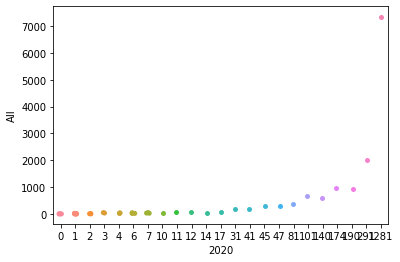

In [ ]:
sns.stripplot(x="2020", y="All", data=dfc)


In [ ]:
sns.stripplot(x="count_color",y=dfc[["2016","2017","2018","2019","2020"]],data=dfc,jitter=True,palette='Set1')

ValueError: Could not interpret input 'count_color'

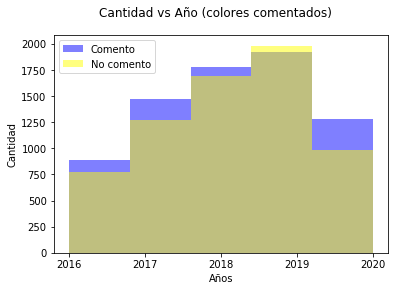

In [ ]:
fig, ax = plt.subplots()

ax.hist(df_usuarios[df_usuarios["count_bin_color"]=="1"]["año"], bins=5, alpha=0.5, color="blue", label="Comento")
ax.hist(df_usuarios[df_usuarios["count_bin_color"]=="0"]["año"], bins=5, alpha=0.5, color="yellow", label="No comento")

ax.set_xlabel("Años")
ax.set_ylabel("Cantidad")

fig.suptitle("Cantidad vs Año (colores comentados)")

ax.legend();

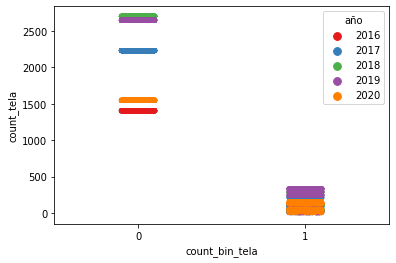

In [ ]:
sns.stripplot(x="count_bin_tela",y="count_tela",data=df_usuarios,jitter=True,hue="año",palette='Set1')


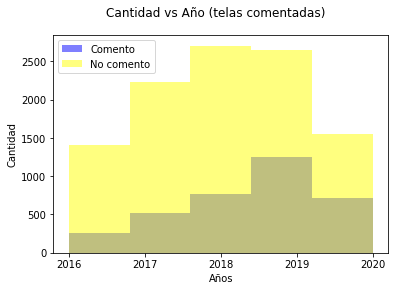

In [ ]:
fig, ax = plt.subplots()

ax.hist(df_usuarios[df_usuarios["count_bin_tela"]=="1"]["año"], bins=5, alpha=0.5, color="blue", label="Comento")
ax.hist(df_usuarios[df_usuarios["count_bin_tela"]=="0"]["año"], bins=5, alpha=0.5, color="yellow", label="No comento")

ax.set_xlabel("Años")
ax.set_ylabel("Cantidad")

fig.suptitle("Cantidad vs Año (telas comentadas)")

ax.legend();

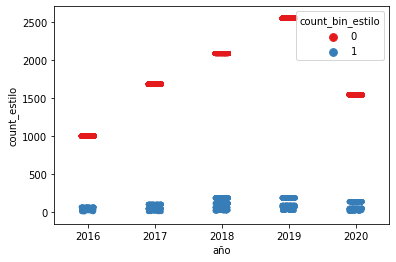

In [ ]:
sns.stripplot(x="año",y="count_estilo",data=df_usuarios,jitter=True,hue="count_bin_estilo",palette='Set1')

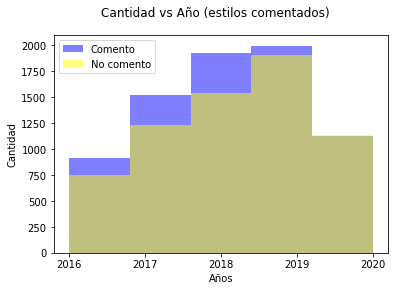

In [ ]:
fig, ax = plt.subplots()

ax.hist(df_usuarios[df_usuarios["count_bin_estilo"]=="1"]["año"], bins=5, alpha=0.5, color="blue", label="Comento")
ax.hist(df_usuarios[df_usuarios["count_bin_estilo"]=="0"]["año"], bins=5, alpha=0.5, color="yellow", label="No comento")

ax.set_xlabel("Años")
ax.set_ylabel("Cantidad")

fig.suptitle("Cantidad vs Año (estilos comentados)")

ax.legend();

#### Dataframe por año en que los usuarios comentaron atributo - Color

In [ ]:
df_usuarios.groupby('año').count()

,id,usuario_id,usuario,creado,Num_seguidores,repin_count,color,tela,estilo,mes,Count_d,Count_m,Count_y,count_color,count_tela,count_estilo,count_bin_color,count_bin_tela,count_bin_estilo,count_usuario
año,,,,,,,,,,,,,,,,,,,,
2016,1665,1665,1575,1665,1665,1665,891,260,918,1665,1665,1665,1665,1665,1665,1665,1665,1665,1665,1665
2017,2749,2749,2587,2749,2749,2749,1475,517,1517,2749,2749,2749,2749,2749,2749,2749,2749,2749,2749,2749
2018,3468,3468,3338,3468,3468,3468,1774,765,1926,3468,3468,3468,3468,3468,3468,3468,3468,3468,3468,3468
2019,3900,3900,3787,3900,3900,3900,1919,1252,1996,3900,3900,3900,3900,3900,3900,3900,2395,2395,2395,3900
2020,2261,2261,2224,2261,2261,2261,1281,713,1130,2261,2261,2261,2261,2261,2261,2261,0,0,0,2261


In [ ]:
df_usuarios.groupby('color').size().sort_values(ascending=False)

color
black        2012
white         984
blue          939
pink          665
red           609
green         387
yellow        295
navy          283
orange        184
purple        170
grey           87
brown          81
coral          77
beige          52
turquoise      52
lemon          50
royal          45
teal           41
olive          35
peach          34
wine           34
rosa           32
azul           26
mustard        26
negro          25
blanco         24
lilac          21
verde          20
rojo           13
amarillo        8
salmon          6
turquesa        5
assorted        3
naranja         3
morado          2
varios          2
marron          2
dorado          2
cafe            2
plateado        1
marino          1
dtype: int64

In [ ]:
dfc = df_usuarios.pivot_table('count_color', index='color', columns='año',fill_value=0,margins=False)

In [ ]:
dfc

año,2016,2017,2018,2019,2020
color,,,,,
amarillo,1,1,3,1,2
assorted,2,0,0,0,1
azul,0,9,5,6,6
beige,11,6,10,18,7
black,308,425,505,483,291
blanco,4,4,5,10,1
blue,100,184,227,238,190
brown,14,8,23,19,17
cafe,0,2,0,0,0


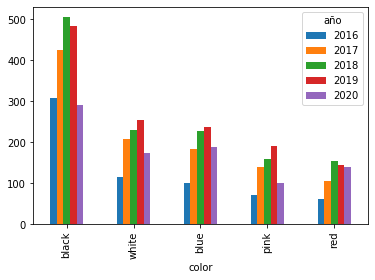

In [ ]:
dfc.sort_values(by="2016" ,ascending=False)[:5].plot(kind="bar")

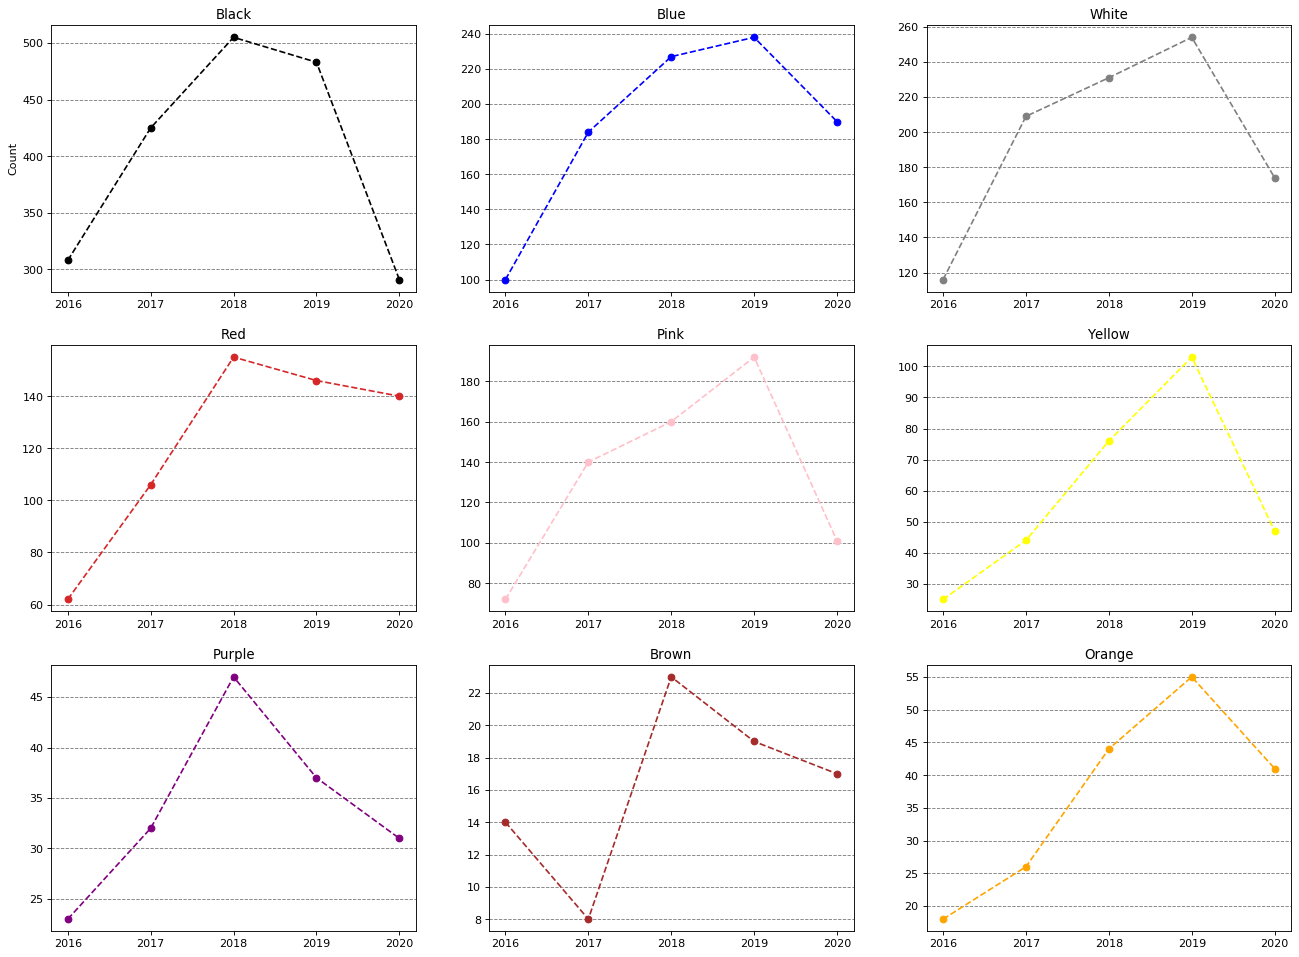

In [ ]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3,3, figsize=(20,15),dpi=80)

ax1.set_title("Black")
ax1.set_ylabel("Count")
ax1.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax1.plot(dfc.loc['black'].index, dfc.loc['black'].values,"black",marker='o', linestyle='dashed')

ax2.set_title("Blue")
ax2.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax2.plot(dfc.loc['blue'].index, dfc.loc['blue'].values,"blue",marker='o', linestyle='dashed')

ax3.set_title("White")
ax3.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax3.plot(dfc.loc['white'].index, dfc.loc['white'].values,"gray",marker='o', linestyle='dashed')

ax4.set_title("Red")
ax4.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax4.plot(dfc.loc['red'].index, dfc.loc['red'].values,"tab:red",marker='o', linestyle='dashed')

ax5.set_title("Pink")
ax5.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax5.plot(dfc.loc['pink'].index, dfc.loc['pink'].values,"pink",marker='o', linestyle='dashed')

ax6.set_title("Yellow")
ax6.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax6.plot(dfc.loc['yellow'].index, dfc.loc['yellow'].values,"YELLOW",marker='o', linestyle='dashed')

ax7.set_title("Purple")
ax7.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax7.plot(dfc.loc['purple'].index, dfc.loc['purple'].values,"purple",marker='o', linestyle='dashed')

ax8.set_title("Brown")
ax8.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax8.plot(dfc.loc['brown'].index, dfc.loc['brown'].values,"brown",marker='o', linestyle='dashed')

ax9.set_title("Orange")
ax9.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax9.plot(dfc.loc['orange'].index, dfc.loc['orange'].values,"orange",marker='o', linestyle='dashed')


In [ ]:
dfcolor = dfc

In [ ]:
dfcolor["All"] = dfcolor.sum(axis=1)

In [ ]:
dfcolor.loc["Total"] = pd.Series(dfcolor[["2016","2017","2018","2019","2020","All"]].sum())

In [ ]:
dfcolor

año,2016,2017,2018,2019,2020,All
color,,,,,,
amarillo,1,1,3,1,2,8
assorted,2,0,0,0,1,3
azul,0,9,5,6,6,26
beige,11,6,10,18,7,52
black,308,425,505,483,291,2012
blanco,4,4,5,10,1,24
blue,100,184,227,238,190,939
brown,14,8,23,19,17,81
cafe,0,2,0,0,0,2


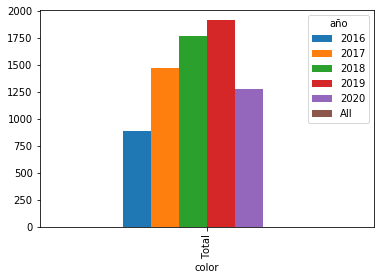

In [ ]:
dfcolor.sort_values(by="2016" ,ascending=False)[:1].plot(kind="bar")

### Telas

In [ ]:
df_usuarios.groupby('tela').size().sort_values(ascending=False)

tela
lace         1060
polyester     645
nylon         586
ribbed        343
textured      160
spandex       138
velvet        136
lycra         122
neoprene      102
elastane       66
poly           38
knitted        31
vinyl          19
scuba          15
voile          14
palma          10
organic         9
tul             5
mezclilla       2
hemp            2
gasa            2
sarga           1
algodon         1
dtype: int64

In [ ]:
dft = df_usuarios.pivot_table('count_tela', index='tela', columns='año',fill_value=0,margins=False)

In [ ]:
dft

año,2016,2017,2018,2019,2020
tela,,,,,
algodon,0,0,0,1,0
elastane,8,10,10,23,15
gasa,0,1,0,1,0
hemp,1,0,1,0,0
knitted,3,4,10,9,5
lace,121,212,283,291,153
lycra,12,8,19,65,18
mezclilla,0,0,0,2,0
neoprene,26,33,14,7,22


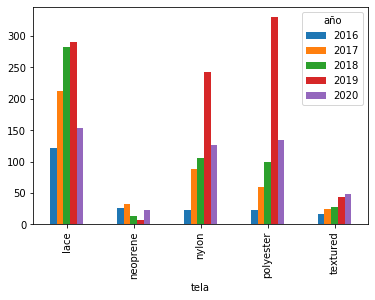

In [ ]:
dft.sort_values(by="2016" ,ascending=False)[:5].plot(kind="bar")

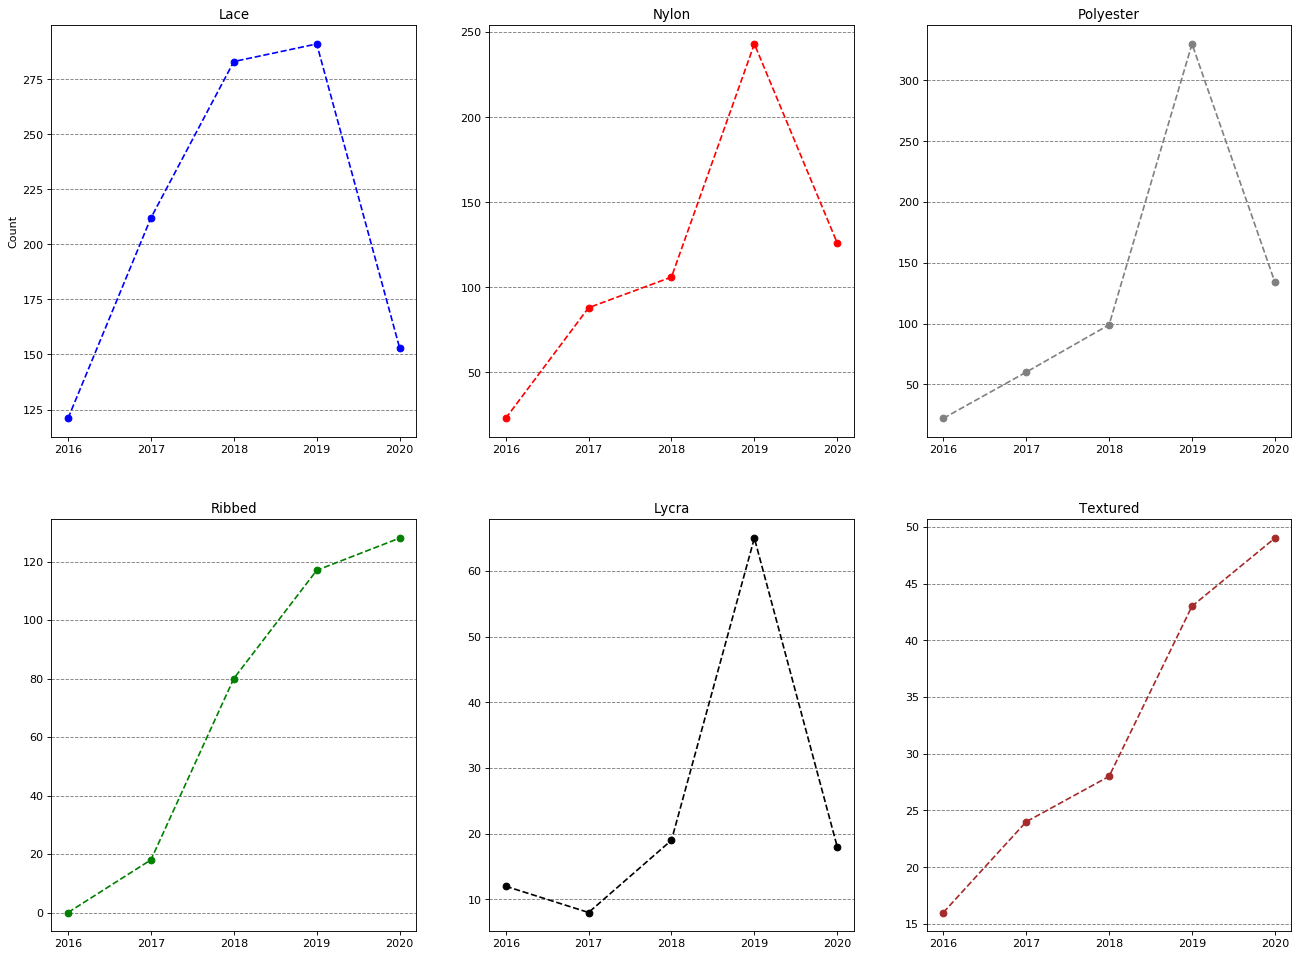

In [ ]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,15),dpi=80)

ax1.set_title("Lace")
ax1.set_ylabel("Count")
ax1.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax1.plot(dft.loc['lace'].index, dft.loc['lace'].values,"blue",marker='o', linestyle='dashed')

ax2.set_title("Nylon")
ax2.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax2.plot(dft.loc['nylon'].index, dft.loc['nylon'].values,"red",marker='o', linestyle='dashed')

ax3.set_title("Polyester")
ax3.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax3.plot(dft.loc['polyester'].index, dft.loc['polyester'].values,"gray",marker='o', linestyle='dashed')

ax4.set_title("Ribbed")
ax4.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax4.plot(dft.loc['ribbed'].index, dft.loc['ribbed'].values,"green",marker='o', linestyle='dashed')

ax5.set_title("Lycra")
ax5.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax5.plot(dft.loc['lycra'].index, dft.loc['lycra'].values,"black",marker='o', linestyle='dashed')

ax6.set_title("Textured")
ax6.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax6.plot(dft.loc['textured'].index, dft.loc['textured'].values,"brown",marker='o', linestyle='dashed')


In [ ]:
dftela = dft

In [ ]:
dftela["All"] = dftela.sum(axis=1)

In [ ]:
dftela.loc["Total"] = pd.Series(dftela[["2016","2017","2018","2019","2020","All"]].sum())

In [ ]:
dftela

año,2016,2017,2018,2019,2020,All
tela,,,,,,
algodon,0,0,0,1,0,1
elastane,8,10,10,23,15,66
gasa,0,1,0,1,0,2
hemp,1,0,1,0,0,2
knitted,3,4,10,9,5,31
lace,121,212,283,291,153,1060
lycra,12,8,19,65,18,122
mezclilla,0,0,0,2,0,2
neoprene,26,33,14,7,22,102


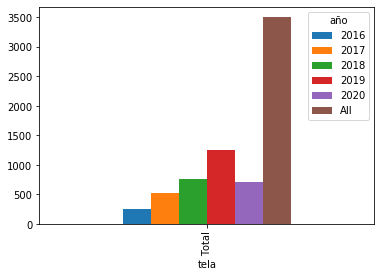

In [ ]:
dftela.sort_values(by="2016" ,ascending=False)[:1].plot(kind="bar")

### Estilo

In [ ]:
df_usuarios.groupby('estilo').size().sort_values(ascending=False)

estilo
one piece       4186
ruffle          1026
sport            872
classic          384
straples         284
thong            272
one shoulder     261
burkini          128
normal            71
1 piece            3
dtype: int64

In [ ]:
dfe = df_usuarios.pivot_table('count_estilo', index='estilo', columns='año',fill_value=0,margins=False)

In [ ]:
dfe

año,2016,2017,2018,2019,2020
estilo,,,,,
1 piece,1,0,0,2,0
burkini,5,5,14,96,8
classic,43,78,91,108,64
normal,3,10,28,17,13
one piece,574,940,1048,1018,606
one shoulder,11,39,74,77,60
ruffle,103,153,284,298,188
sport,127,212,205,197,131
straples,31,37,76,117,23


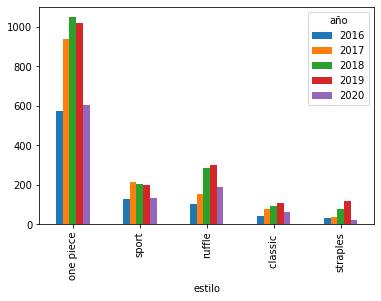

In [ ]:
dfe.sort_values(by="2016" ,ascending=False)[:5].plot(kind="bar")

KeyError: 'classic'

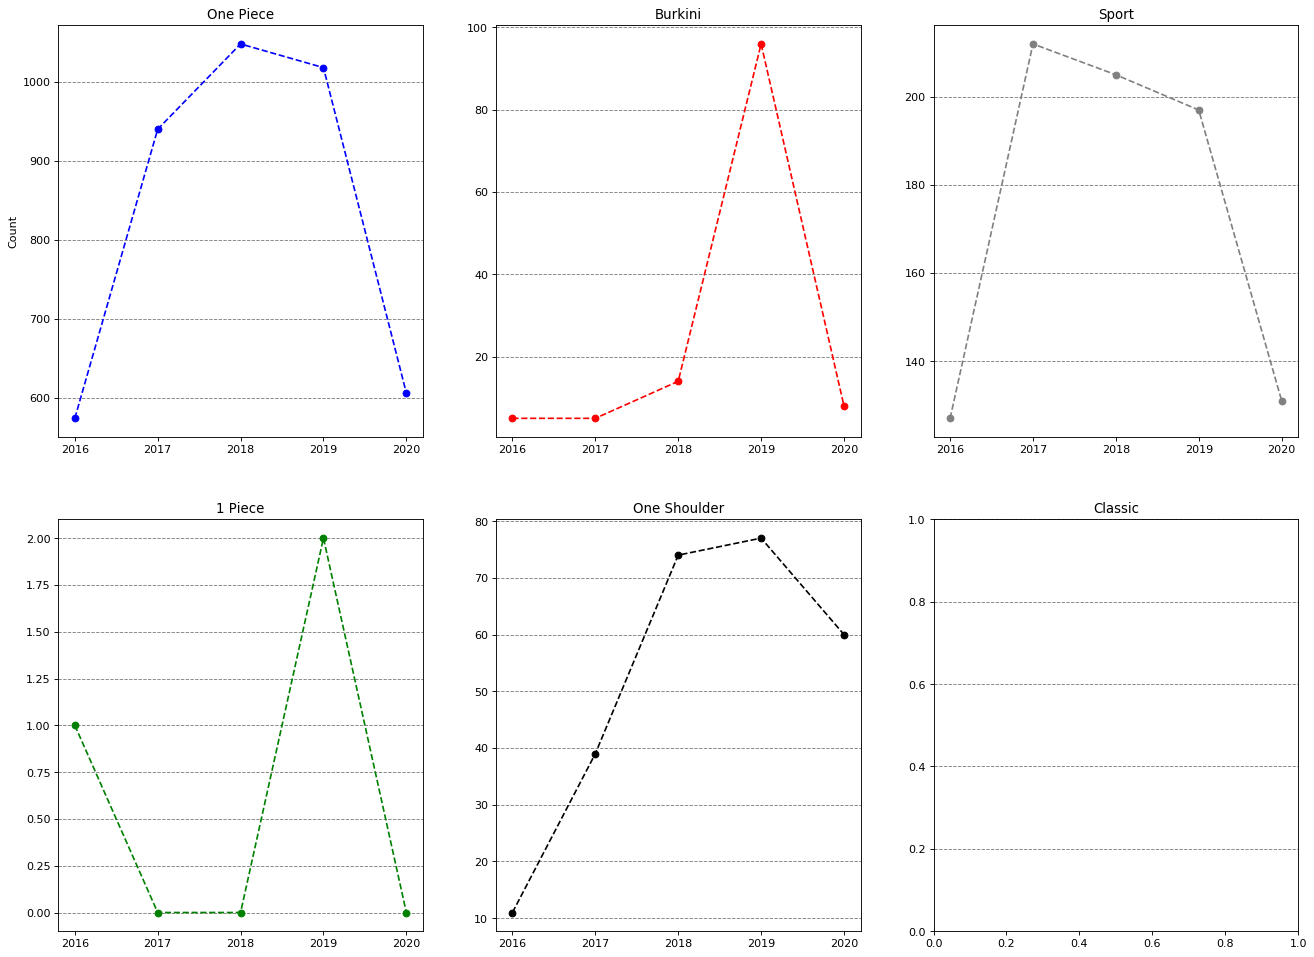

In [ ]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(20,15),dpi=80)

ax1.set_title("One Piece")
ax1.set_ylabel("Count")
ax1.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax1.plot(dfe.loc['one piece'].index, dfe.loc['one piece'].values,"blue",marker='o', linestyle='dashed')

ax2.set_title("Burkini")
ax2.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax2.plot(dfe.loc['burkini'].index, dfe.loc['burkini'].values,"red",marker='o', linestyle='dashed')

ax3.set_title("Sport")
ax3.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax3.plot(dfe.loc['sport'].index, dfe.loc['sport'].values,"gray",marker='o', linestyle='dashed')

ax4.set_title("1 Piece")
ax4.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax4.plot(dfe.loc['1 piece'].index, dfe.loc['1 piece'].values,"green",marker='o', linestyle='dashed')

ax5.set_title("One Shoulder")
ax5.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax5.plot(dfe.loc['one shoulder'].index, dfe.loc['one shoulder'].values,"black",marker='o', linestyle='dashed')

ax6.set_title("Classic")
ax6.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
ax6.plot(dfe.loc['classic'].index, dfe.loc['classic'].values,"brown",marker='o', linestyle='dashed')


In [ ]:
dfestilo = dfe

In [ ]:
dfestilo["All"] = dfestilo.sum(axis=1)

In [ ]:
dfestilo.loc["Total"] = pd.Series(dfestilo[["2016","2017","2018","2019","2020","All"]].sum())

In [ ]:
dfestilo

año,2016,2017,2018,2019,2020,All
estilo,,,,,,
1 piece,1,0,0,2,0,3
burkini,5,5,14,96,8,128
classic,43,78,91,108,64,384
normal,3,10,28,17,13,71
one piece,574,940,1048,1018,606,4186
one shoulder,11,39,74,77,60,261
ruffle,103,153,284,298,188,1026
sport,127,212,205,197,131,872
straples,31,37,76,117,23,284


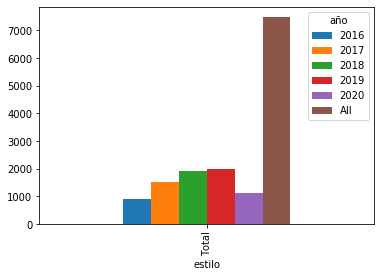

In [ ]:
dfestilo.sort_values(by="2016" ,ascending=False)[:1].plot(kind="bar")

## Analisis Exploratorio por usuario y atributo

#### Usuarios unicos que mencionaron al menos un atributo dentro de la temporada (mar-sep) entre (2016-2020)

##### Numero de usuarios unicos

In [ ]:
df_usuarios.usuario_id.nunique()

2984

In [ ]:
df_usuarios['count_usuario'] = df_usuarios.groupby(['usuario_id','año'])['usuario_id'].transform('size')

In [ ]:
df_usuarios['count_usuario_c'] = df_usuarios.groupby(['usuario_id','color','año'])['usuario_id'].transform('size')
df_usuarios['count_usuario_t'] = df_usuarios.groupby(['usuario_id','tela','año'])['usuario_id'].transform('size')
df_usuarios['count_usuario_e'] = df_usuarios.groupby(['usuario_id','estilo','año'])['usuario_id'].transform('size')

In [ ]:
df_usuarios.groupby(['usuario_id','tela','año'])['usuario_id'].count()


usuario_id  tela       año 
3           lace       2016    1
                       2019    1
4           lace       2017    2
                       2018    3
                       2019    2
                              ..
2976        lace       2020    1
2978        lace       2020    1
2979        textured   2020    1
2982        polyester  2020    1
2983        ribbed     2020    1
Name: usuario_id, Length: 1376, dtype: int64

In [ ]:
df_usuarios

,id,usuario_id,usuario,creado,Num_seguidores,repin_count,color,tela,estilo,año,...,count_color,count_tela,count_estilo,count_bin_color,count_bin_tela,count_bin_estilo,count_usuario,count_usuario_c,count_usuario_t,count_usuario_e
0,129689664247791019,0,POPSUGARFitness,2016-03-01,748646,13,NaN,NaN,one piece,2016,...,774,1405,574,1,0,0,6,NaN,NaN,3.0
1,482659285045663298,1,https://www.pinterest.com/guzmncelis/,2016-03-01,0,0,black,NaN,NaN,2016,...,308,1405,747,1,0,0,2,1.0,NaN,NaN
2,43558321373797279,2,https://www.pinterest.com/madvintage/,2016-03-01,0,0,royal,NaN,NaN,2016,...,5,1405,747,0,0,1,1,1.0,NaN,NaN
3,492651646718979160,3,DressTrendscom,2016-03-01,2781,1,NaN,NaN,sport,2016,...,774,1405,127,0,1,0,2,NaN,NaN,1.0
4,223420831492840339,4,target,2016-03-01,4287730,0,NaN,NaN,one piece,2016,...,774,1405,574,0,1,0,7,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14038,690035974151076437,684,formalhouse,2020-09-29,0,0,beige,NaN,NaN,2020,...,7,1548,1131,NaN,NaN,NaN,2,1.0,NaN,NaN
14039,170503535881842463,2983,https://www.pinterest.com/picatoria/,2020-09-29,0,0,NaN,ribbed,one piece,2020,...,980,128,606,NaN,NaN,NaN,1,NaN,1.0,1.0
14040,98094098123977732,1973,seokingz,2020-09-30,10785,3,black,NaN,one piece,2020,...,291,1548,606,NaN,NaN,NaN,2,2.0,NaN,1.0
14041,52706258127631437,2714,weddingwire,2020-09-30,526393,555,white,NaN,NaN,2020,...,174,1548,1131,NaN,NaN,NaN,2,1.0,NaN,NaN


In [ ]:
dfu = df_usuarios.pivot_table('count_usuario', index='usuario_id', columns='año',fill_value=0,margins=False)

In [ ]:
dfu

año,2016,2017,2018,2019,2020
usuario_id,,,,,
0,6,0,0,0,0
1,2,0,0,0,0
2,1,0,0,0,0
3,2,0,1,1,0
4,7,15,16,17,4
...,...,...,...,...,...
2979,0,0,0,0,1
2980,0,0,0,0,1
2981,0,0,0,0,1


#### Color

In [ ]:
dfuc = df_usuarios.pivot_table('count_usuario_c', index=df_usuarios[['usuario_id','color']], columns='año',fill_value=0)

In [ ]:
dfuc

año               2016  2017  2018  2019  2020
usuario_id color                              
1          black     1     0     0     0     0
2          royal     1     0     0     0     0
3          blue      1     0     0     0     0
4          beige     0     0     0     2     0
           black     2     3     5     2     0
...                ...   ...   ...   ...   ...
2973       navy      0     0     0     0     1
2974       black     0     0     0     0     3
2975       red       0     0     0     0     1
2976       red       0     0     0     0     1
2980       rosa      0     0     0     0     1

[2879 rows x 5 columns]

In [ ]:
dfuc["All"] = dfuc.sum(axis=1)

In [ ]:
dfuc.loc["Total"] = pd.Series(dfuc[["2016","2017","2018","2019","2020","All"]].sum())

In [ ]:
dfuc

año,2016,2017,2018,2019,2020,All
"(1, black)",1,0,0,0,0,1
"(2, royal)",1,0,0,0,0,1
"(3, blue)",1,0,0,0,0,1
"(4, beige)",0,0,0,2,0,2
"(4, black)",2,3,5,2,0,12
...,...,...,...,...,...,...
"(2974, black)",0,0,0,0,3,3
"(2975, red)",0,0,0,0,1,1
"(2976, red)",0,0,0,0,1,1
"(2980, rosa)",0,0,0,0,1,1


### Tela

In [ ]:
dfut = df_usuarios.pivot_table('count_usuario_t', index=df_usuarios[['usuario_id','tela']], columns='año',fill_value=0)

In [ ]:
dfut

año                   2016  2017  2018  2019  2020
usuario_id tela                                   
3          lace          1     0     0     1     0
4          lace          0     2     3     2     0
           ribbed        0     0     0     3     0
           textured      0     0     0     0     2
5          voile         1     0     0     0     0
...                    ...   ...   ...   ...   ...
2976       lace          0     0     0     0     1
2978       lace          0     0     0     0     1
2979       textured      0     0     0     0     1
2982       polyester     0     0     0     0     1
2983       ribbed        0     0     0     0     1

[1086 rows x 5 columns]

In [ ]:
dfut["All"] = dfut.sum(axis=1)

In [ ]:
dfut.loc["Total"] = pd.Series(dfut[["2016","2017","2018","2019","2020","All"]].sum())

In [ ]:
dfut

año,2016,2017,2018,2019,2020,All
"(3, lace)",1,0,0,1,0,2
"(4, lace)",0,2,3,2,0,7
"(4, ribbed)",0,0,0,3,0,3
"(4, textured)",0,0,0,0,2,2
"(5, voile)",1,0,0,0,0,1
...,...,...,...,...,...,...
"(2978, lace)",0,0,0,0,1,1
"(2979, textured)",0,0,0,0,1,1
"(2982, polyester)",0,0,0,0,1,1
"(2983, ribbed)",0,0,0,0,1,1


### Estilo

In [ ]:
dfue = df_usuarios.pivot_table('count_usuario_e', index=df_usuarios[['usuario_id','estilo']], columns='año',fill_value=0)

In [ ]:
dfue

año                   2016  2017  2018  2019  2020
usuario_id estilo                                 
0          one piece     3     0     0     0     0
           sport         3     0     0     0     0
1          one piece     1     0     0     0     0
3          classic       0     0     1     0     0
           sport         1     0     0     0     0
...                    ...   ...   ...   ...   ...
2976       ruffle        0     0     0     0     1
2977       ruffle        0     0     0     0     1
2981       sport         0     0     0     0     1
2982       normal        0     0     0     0     1
2983       one piece     0     0     0     0     1

[2275 rows x 5 columns]

In [ ]:
dfue["All"] = dfue.sum(axis=1)

In [ ]:
dfue.loc["Total"] = pd.Series(dfue[["2016","2017","2018","2019","2020","All"]].sum())

In [ ]:
dfue

año,2016,2017,2018,2019,2020,All
"(0, one piece)",3,0,0,0,0,3
"(0, sport)",3,0,0,0,0,3
"(1, one piece)",1,0,0,0,0,1
"(3, classic )",0,0,1,0,0,1
"(3, sport)",1,0,0,0,0,1
...,...,...,...,...,...,...
"(2977, ruffle)",0,0,0,0,1,1
"(2981, sport)",0,0,0,0,1,1
"(2982, normal)",0,0,0,0,1,1
"(2983, one piece)",0,0,0,0,1,1


In [ ]:
dfu_tri = df_usuarios.pivot_table(df_usuarios[['count_usuario_c','count_usuario_t','count_usuario_e']], index=df_usuarios[['usuario_id','color','tela','estilo']], columns='año',fill_value=0)


In [ ]:
dfu_tri

count_usuario_c                               count_usuario_e       \
año                   2016      2017 2018      2019 2020            2016 2017   
usuario_id                                                                      
0                      0.0  0.000000  0.0  0.000000  0.0             3.0  0.0   
1                      1.0  0.000000  0.0  0.000000  0.0             1.0  0.0   
2                      1.0  0.000000  0.0  0.000000  0.0             0.0  0.0   
3                      1.0  0.000000  0.0  0.000000  0.0             1.0  0.0   
4                      1.8  2.555556  3.2  2.454545  1.0             1.0  1.4   
...                    ...       ...  ...       ...  ...             ...  ...   
2979                   0.0  0.000000  0.0  0.000000  0.0             0.0  0.0   
2980                   0.0  0.000000  0.0  0.000000  1.0             0.0  0.0   
2981                   0.0  0.000000  0.0  0.000000  0.0             0.0  0.0   
2982                   0.0  0.000000  0.0  0.000000  0.0             0.0  0.0   
2983                   0.0  0.000000  0.0  0.000000  0.0             0.0  0.0   

                                count_usuario_t                      
año         2018      2019 2020            2016 2017 2018 2019 2020  
usuario_id                                                           
0           0.00  0.000000  0.0             0.0  0.0  0.0  0.0  0.0  
1           0.00  0.000000  0.0             0.0  0.0  0.0  0.0  0.0  
2           0.00  0.000000  0.0             0.0  0.0  0.0  0.0  0.0  
3           1.00  0.000000  0.0             1.0  0.0  0.0  1.0  0.0  
4           3.75  6.636364  2.0             0.0  2.0  3.0  2.6  2.0  
...          ...       ...  ...             ...  ...  ...  ...  ...  
2979        0.00  0.000000  0.0             0.0  0.0  0.0  0.0  1.0  
2980        0.00  0.000000  0.0             0.0  0.0  0.0  0.0  0.0  
2981        0.00  0.000000  1.0             0.0  0.0  0.0  0.0  0.0  
2982        0.00  0.000000  1.0             0.0  0.0  0.0  0.0  1.0  
2983        0.00  0.000000  1.0             0.0  0.0  0.0  0.0  1.0  

[2984 rows x 15 columns]

convertir str columna de año y de mes

In [ ]:
#Pines_vogue[(Pines_vogue.usuario_id == "215821144551327809") & (Pines_vogue.creado == "2017")]


## Analisis de atributos

In [ ]:
df["atributo_color_1"].unique()

array([None, 'red', 'royal', 'black', 'pink', 'yellow', 'blue', 'brown',
       'green', 'white', 'lemon', 'coral', 'negro', 'navy', 'salmon',
       'purple', 'grey', 'beige', 'verde', 'wine', 'blanco', 'turquoise',
       'peach', 'lilac', 'teal', 'olive', 'assorted', 'rojo', 'orange',
       'rosa', 'mustard', 'amarillo', 'azul', 'cafe', 'marino', 'marron',
       'turquesa', 'neon orange', 'naranja', 'dorado', 'morado',
       'plateado', 'varios'], dtype=object)

In [ ]:
df.atributo_color_1.nunique()

42

In [ ]:
df_atributos_tag.atributo_color_1.nunique()

43

In [ ]:
dfc = df.atributo_color.value_counts()

In [ ]:
df.atributo_color.value_counts().sum()

17908

In [ ]:
df.atributo_tela.value_counts().sum()

9048

In [ ]:
df.atributo_estilo.value_counts().sum()

32422

In [ ]:
dfc.head()

red      4180
black    3982
white    1916
blue     1906
pink     1376
Name: atributo_color, dtype: int64

In [ ]:
df_atributos["atributo_estilo_1"].unique()

array(['one piece', 0, 'sport', 'ruffle', 'one shoulder', 'straples',
       'classic ', 'thong', 'burkini', 'normal', '1 piece'], dtype=object)

In [ ]:
df.atributo_tela.nunique()

25

In [ ]:
dft = df.atributo_tela.value_counts()

In [ ]:
df["atributo_estilo"].unique()

array(['bikini', None, 'monokini', 'halter', 'sport', 'bandeau', 'top',
       'bottom', 'tankini', 'ruffle', 'swimdress', 'classic', 'thong',
       'wetsuit', 'skirtini', 'legsuit', 'burkini', 'trikini', 'mayo'],
      dtype=object)

In [ ]:
df.atributo_estilo.nunique()

18

In [ ]:
dfe = df.atributo_estilo.value_counts()

## Graficas de analisis de atributos

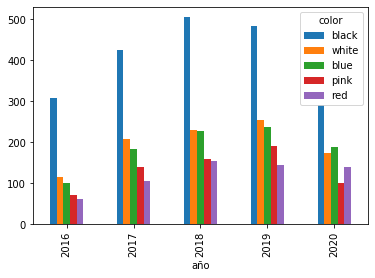

In [ ]:
dfcolor.iloc[:10].plot.bar()

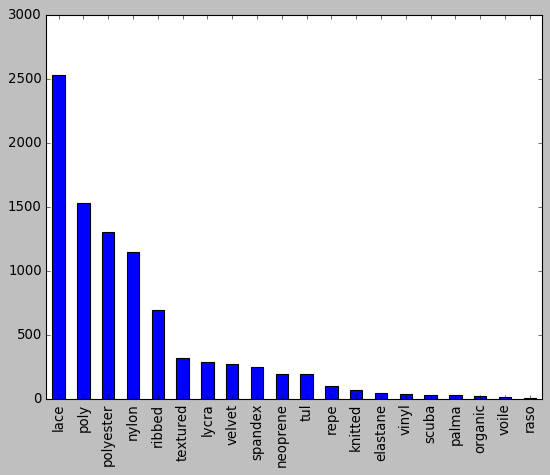

In [ ]:
dft.iloc[:20].plot.bar()

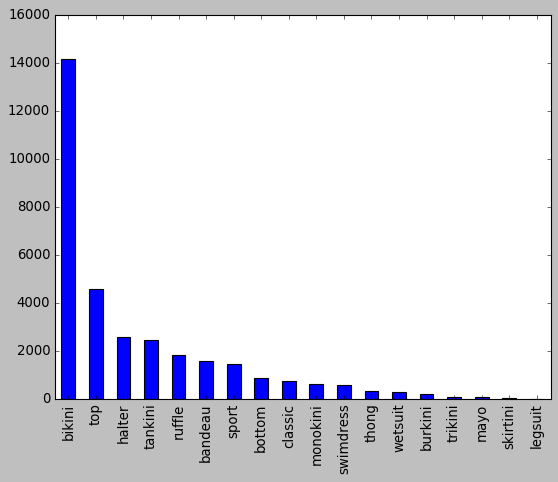

In [ ]:
dfe.iloc[:20].plot.bar()

In [ ]:
df_atributos.to_csv('pins_entrenamiento.csv')

In [ ]:
dt.to_csv('pins_prueba.csv')

In [ ]:
number = preprocessing.LabelEncoder()
df["atributo_color"] = number.fit_transform(df["atributo_color"].astype("str"))
df["atributo_tela"] = number.fit_transform(df["atributo_tela"].astype("str"))
df["atributo_estilo"] = number.fit_transform(df["atributo_estilo"].astype("str"))

In [ ]:
df

,id,usuario_id,usuario,dominio,creado,Num_seguidores,repin_count,atributo_color,atributo_tela,atributo_estilo,color,tela,estilo
0,313140980321868905,259801609662367008.00,urbanoutfitters,urbanoutfitters.com,2016-03-01,3059122,1,None,None,bikini,0,0,1
1,465700417698566187,45176939920493432.00,nymag,nymag.com,2016-03-01,180274,0,red,None,None,1,0,0
2,407857309985061022,326933391607916864.00,weloveboho,weloveboho.com,2016-03-01,201442,0,None,None,monokini,0,0,1
3,129689664247791019,129689801677865344.00,POPSUGARFitness,popsugar.com,2016-03-01,748646,13,None,None,halter,0,0,1
4,492651646718979160,465559817637892800.00,DressTrendscom,dress-trends.com,2016-03-01,2781,1,None,None,sport,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41071,522417625531539654,23432997969621924.00,theposhmarkapp,poshmark.com,2020-09-30,683439,0,None,None,top,0,0,1
41072,56224695337645650,23432997969621924.00,theposhmarkapp,poshmark.com,2020-09-30,683462,0,pink,None,bikini,1,0,1
41073,451697037631534192,451697175034861568.00,nanamacs,nanamacs.com,2020-09-30,51104,0,None,None,top,0,0,1
41074,52706258127631437,52706395547501048.00,weddingwire,weddingwire.com,2020-09-30,526393,555,white,None,None,1,0,0


### Deteccion de dominios en comentarios

In [ ]:
comments = pines[pines['comentarios'].str.contains(r'http\S+(?!$)')].reset_index()

In [ ]:
comments.head()

,index,Unnamed: 0,id,userId,dominio,img_Url,comentarios,creado,follower_count,locale,comentarios_tokenizados
0,62,62,191825265356401788,20196035737420646,instyle.com,https://i.pinimg.com/originals/bf/04/8b/bf048b...,"Look of the Day | <a href=""http://InStyle.com""...",2016,1157318,en-US,"[look, day, rel, nofollow, target, blank, inst..."
1,98,98,595812225674286441,pt-BR,s.click.aliexpress.com,https://i.pinimg.com/originals/79/d2/35/79d235...,US $10.58 -- Women White Halter V Neck Scallop...,2017,612,en-US,"[us, 10, 58, women, white, halter, neck, scall..."
2,121,121,492649937685869,412009203318670708,cupshe.com,https://i.pinimg.com/originals/1a/cb/7f/1acb7f...,It's most certainly about keeping you trendy! ...,2016,481596,en-US,"[certainly, keeping, trendy, shop, fantastic, ..."
3,125,125,492649943767359,492787367730239,Uploaded by user,https://i.pinimg.com/originals/ff/d4/04/ffd404...,"Best Tankini Swimsuits 2016 On <a href=""http:/...",2018,0,NaN,"[best, tankini, swimsuits, 2016, rel, nofollow..."
4,132,132,139682025921035754,139682163351096440,stylelovely.com,https://i.pinimg.com/originals/3b/16/12/3b1612...,"Sports Illustrated Party 2016 <a href=""http://...",2016,296362,es-ES,"[sports, illustrated, party, 2016, rel, nofoll..."


In [ ]:
comments['comentarios'][87]

'<a href="https://jschristina-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/tie-dye-matching-couples-vacation-outfit-kenny-flowers-watercolors-bikini-hawaiian-shirt.jpg" rel="nofollow" target="_blank">jschristina-wpeng...</a>'

In [ ]:
def limpieza_url(comentarios):
    #Conversion a minúsculas
    comentario = comentarios.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\;\\<\\>\\@\\[\\]\\^_\\`\\{\\|\\}\\~]'
    comentario = re.sub(regex , ' ', comentario)
    # Eliminación de espacios en blanco múltiples
    comentario = re.sub("\\s+", ' ', comentario)
    # Tokenización por palabras individuales
    comentario = comentario.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    comentario = [token for token in comentario if len(token) > 1]
    # Eliminacion de las StopWords
    stop_words = set(stopwords.words('english'))
    comentario = [w for w in comentario if not w.lower() in stop_words]

    return(comentario)

In [ ]:
comments['token_url'] = comments['comentarios'].apply(lambda x: limpieza_url(x))

In [ ]:
comments['token_url'][0]

['look',
 'day',
 'href=',
 'http://instyle.com',
 'rel=',
 'nofollow',
 'target=',
 'blank',
 'instyle.com',
 '/a']

In [ ]:
urls = []
for com in comments['token_url']:
    for elem in com:
        if "http" in elem:
            urls.append(elem)


In [ ]:
urls = list(dict.fromkeys(urls))

In [ ]:
f = urllib.request.urlopen(urls[0])
mylist = f.read()

In [ ]:
# the target we want to open
url='https://latam.zaful.com/bikinis-e_67/'

#open with GET method
resp=requests.get(url)

#http_respone 200 means OK status
if resp.status_code==200:
    print("Successfully opened the web page")
    print("The comments of images are stored")

    # we need a parser,Python built-in HTML parser is enough .
    soup=BeautifulSoup(resp.text,'html.parser')
    # l is the list which contains all the text i.e news
    results=soup.find_all("li",{"class":"js_proList_item logsss_event_ps"})
    records = []

    for result in results:
        comment = result.find('a', attrs={'class':'js_list_link js_list_title logsss_event_cl'})
        records.append(comment)

'if resp.status_code==200:\n    print("Successfully opened the web page")\n    print("The comments of images are stored")\n      \n    # we need a parser,Python built-in HTML parser is enough .\n    soup=BeautifulSoup(resp.text,\'html.parser\')    \n    # l is the list which contains all the text i.e news \n    results=soup.find_all("li",{"class":"js_proList_item logsss_event_ps"})\n    records = []  \n        \n    for result in results:  \n        comment = result.find(\'a\', attrs={\'class\':\'js_list_link js_list_title logsss_event_cl\'})\n        records.append(comment) '

#### "El servidor se niega a darnos la informacion por eso la respuesta 403"

In [ ]:
import requests
r = requests.get('https://latam.zaful.com/bikinis-e_67/')
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.text, 'html.parser')
results=soup.find_all("ul",{"class":"js_proList_item logsss_event_ps"})
records = []

for result in results:
    comment = result.find('a', attrs={'class':'js_list_link js_list_title logsss_event_cl'})
    records.append(comment)

In [ ]:
r

<Response [403]>

In [ ]:
records.rename(columns = {0 : "comentarios"},inplace=True)

In [ ]:
records = records.replace(to_replace='None', value=np.nan).dropna()

In [ ]:
records['comentarios'] = records['comentarios'].astype(str)

In [ ]:
records['comentarios'] = records['comentarios'].apply(lambda x: limpieza_tokens(x))

### Dominios con mas imagenes en DataFrame

In [ ]:
df = pines.drop(columns=["Unnamed: 0","comentarios","comentarios_tokenizados","locale"], axis= 1).reset_index()

In [ ]:
df

,index,id,userId,dominio,img_Url,creado,follower_count
0,2,619878336184764172,619878473619487575,gettyimages.dk,https://i.pinimg.com/originals/35/c7/53/35c753...,2018,0
1,4,405112928962505039,199003014692866089,zimbio.com,https://i.pinimg.com/originals/78/4f/57/784f57...,2016,845505
2,6,555209460293313897,199003014692866089,zimbio.com,https://i.pinimg.com/originals/24/95/58/249558...,2016,845505
3,7,46584177382998813,46584314804047480,Uploaded by user,https://i.pinimg.com/originals/a1/5b/bd/a15bbd...,2019,0
4,8,474918723208336210,807974126806387335,aliexpress.com,https://i.pinimg.com/originals/89/a5/c4/89a5c4...,2019,2882212
...,...,...,...,...,...,...,...
30435,43762,690810030346891954,690810167750683901,damenmode-quelle.de,https://i.pinimg.com/originals/42/cd/16/42cd16...,2021,0
30436,43763,703476404293017924,703476541702626274,damenmode-quelle.de,https://i.pinimg.com/originals/9e/1b/6f/9e1b6f...,2021,0
30437,43768,703476404295046546,703476541702626274,damenmode-quelle.de,https://i.pinimg.com/originals/1d/43/98/1d4398...,2021,0
30438,43771,703476404290506843,703476541702626274,damenmode-quelle.de,https://i.pinimg.com/originals/93/7d/8a/937d8a...,2020,0


In [ ]:
df["creado"] = pd.to_numeric(df["creado"])

In [ ]:
df = pd.concat([df, C, T, E], axis=1, ignore_index=True)

In [ ]:
df.sort_values(by=["creado"],ascending=True)

,id,usuario_id,dominio,url,creado,Num_seguidores,atributo_color,atributo_tela,atributo_estilo
28729,188940146836610009,29203234992160770,dorotheasclosetvintage.com,https://i.pinimg.com/originals/16/f4/a6/16f4a6...,2011,16303,None,None,None
6110,25121710390967442,4011224576560993,oldnavy.gap.com,https://i.pinimg.com/originals/4b/00/12/4b0012...,2011,342697,None,None,None
6193,53832158016186006,129549064189510195,athleta.gap.com,https://i.pinimg.com/originals/92/f3/ca/92f3ca...,2012,84015,None,None,None
9602,78461218478233411,en-US,Uploaded by user,https://i.pinimg.com/originals/bd/83/ce/bd83ce...,2012,13682,None,None,None
24935,169448004701308416,169448142138250389,cosmopolitan.com,https://i.pinimg.com/originals/6b/5a/a1/6b5aa1...,2012,0,None,None,None
...,...,...,...,...,...,...,...,...,...
16834,1122522275843765692,1122522413280556282,roselandy.com,https://i.pinimg.com/originals/ce/99/c7/ce99c7...,2021,3660,None,polyester,None
16833,1122522275844016399,1122522413280556282,roselandy.com,https://i.pinimg.com/originals/b6/06/91/b60691...,2021,3660,white,None,ruffle
16832,1122522275843610944,1122522413280556282,roselandy.com,https://i.pinimg.com/originals/12/72/f0/1272f0...,2021,3660,yellow,polyester,None
16830,1122522275843589179,1122522413280556282,roselandy.com,https://i.pinimg.com/originals/d7/22/79/d72279...,2021,3660,green,None,ruffle


### Deteccion de los dominios predominantes

In [ ]:
df = df.rename(columns={0:"index",1:"id",2:"usuario_id",3:"dominio",4:"url",5:"creado",6:"Num_seguidores",7:"atributo_color",8:"atributo_tela",9:"atributo_estilo"})

In [ ]:
df = df.drop(["index"], axis=1)

In [ ]:
Followers = df["Num_seguidores"]

In [ ]:
Followers.describe()

count    3.044000e+04
mean     3.596021e+05
std      9.227117e+05
min      0.000000e+00
25%      3.530000e+02
50%      4.452000e+03
75%      3.534070e+05
max      2.411523e+07
Name: Num_seguidores, dtype: float64

In [ ]:
dt = df.groupby("dominio")

In [ ]:
dt.size().sort_values(ascending=False)[:10]

dominio
vogue.com            1061
Uploaded by user     1039
zaful.com             887
lightinthebox.com     641
cupshe.com            620
etsy.com              579
roselandy.com         521
rosegal.com           480
laleela.com           415
2daydeliver.com       337
dtype: int64

In [ ]:
Pines_vogue = dt.get_group("vogue.com")
Pines_vogue.sort_values(by=["creado"],ascending=True)


,id,usuario_id,dominio,url,creado,Num_seguidores,atributo_color,atributo_tela,atributo_estilo
11155,403987029053228360,215821144551327809,vogue.com,https://i.pinimg.com/originals/a3/4c/39/a34c39...,2015,2181432,None,None,None
5892,426505027189687950,215821144551327809,vogue.com,https://i.pinimg.com/originals/fb/09/1d/fb091d...,2015,2181416,None,None,None
8319,536139530619998530,215821144551327809,vogue.com,https://i.pinimg.com/originals/be/53/eb/be53eb...,2015,2181421,None,None,None
5901,393783561147828645,215821144551327809,vogue.com,https://i.pinimg.com/originals/4b/e0/ca/4be0ca...,2015,2181416,None,None,None
9858,5911043239749115,215821144551327809,vogue.com,https://i.pinimg.com/originals/41/45/1b/41451b...,2015,2181427,None,None,None
...,...,...,...,...,...,...,...,...,...
8696,391179917640967041,215821144551327809,vogue.com,https://i.pinimg.com/originals/70/72/5a/70725a...,2021,2181419,None,None,None
12102,404479610289709616,215821144551327809,vogue.com,https://i.pinimg.com/originals/77/ec/57/77ec57...,2021,2181437,None,None,None
8869,481463016422053991,215821144551327809,vogue.com,https://i.pinimg.com/originals/5d/92/8a/5d928a...,2021,2181420,None,None,None
3862,508203139210434477,215821144551327809,vogue.com,https://i.pinimg.com/originals/88/44/f7/8844f7...,2021,2181405,None,None,None


In [ ]:
Pines_vogue[(Pines_vogue.usuario_id == "215821144551327809") & (Pines_vogue.creado == "2017")]


,id,usuario_id,dominio,url,creado,Num_seguidores,atributo_color,atributo_tela,atributo_estilo
2178,325174035581532461,215821144551327809,vogue.com,https://i.pinimg.com/originals/bd/ba/25/bdba25...,2017,2181398,None,None,None
2233,553661347926079295,215821144551327809,vogue.com,https://i.pinimg.com/originals/94/a8/8a/94a88a...,2017,2181398,None,None,None
2245,247064729541023194,215821144551327809,vogue.com,https://i.pinimg.com/originals/e3/ca/80/e3ca80...,2017,2181398,None,None,None
2458,542683823835658213,215821144551327809,vogue.com,https://i.pinimg.com/originals/ae/ee/9d/aeee9d...,2017,2181399,None,None,top
4100,206673070380823843,215821144551327809,vogue.com,https://i.pinimg.com/originals/64/96/97/649697...,2017,2181405,None,None,None
...,...,...,...,...,...,...,...,...,...
24007,433401164131941772,215821144551327809,vogue.com,https://i.pinimg.com/originals/9b/9b/3f/9b9b3f...,2017,2181481,None,None,None
24097,27866091429743969,215821144551327809,vogue.com,https://i.pinimg.com/originals/da/fb/d2/dafbd2...,2017,2181482,None,None,None
26398,348395721164262613,215821144551327809,vogue.com,https://i.pinimg.com/originals/1b/fc/aa/1bfcaa...,2017,2181501,None,None,None
26580,47569339797897153,215821144551327809,vogue.com,https://i.pinimg.com/originals/48/00/c3/4800c3...,2017,2181502,None,None,None


In [ ]:
Pines_zaful = dt.get_group("zaful.com")
Pines_zaful[(Pines_zaful.usuario_id == "318418773562399503")]

NameError: name 'dt' is not defined

In [ ]:
Pines_lightinthebox = dt.get_group("lightinthebox.com")
Pines_lightinthebox[(Pines_lightinthebox.usuario_id == "76631768567909285")]

,id,usuario_id,dominio,url,creado,Num_seguidores,atributo_color,atributo_tela,atributo_estilo
494,603130575069064334,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/dc/c1/c6/dcc1c6...,2017,784800,None,None,None
2125,125467539605713247,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/ee/32/9f/ee329f...,2019,784807,None,None,None
3990,76631631150098570,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/ef/1c/19/ef1c19...,2021,784811,black,elastane,bottom
4096,76631631150156213,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/46/f9/37/46f937...,2021,784812,blue,None,sport
4244,76631631150098226,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/2c/f8/42/2cf842...,2021,784812,None,None,classic
...,...,...,...,...,...,...,...,...,...
29671,76631631150297922,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/99/58/9e/99589e...,2021,784927,None,None,bottom
29855,76631631150298406,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/a6/13/9b/a6139b...,2021,784930,None,polyester,None
29888,76631631150297884,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/60/2f/1b/602f1b...,2021,784930,None,polyester,None
29892,76631631150323992,76631768567909285,lightinthebox.com,https://i.pinimg.com/originals/a4/47/b5/a447b5...,2021,784930,white,polyester,None


In [ ]:
#año_2016 = df.get_group("2016")
#año_2016 = año_2016.sort_values(by=["Num_seguidores"],ascending=False)
#año_2016

,id,usuario_id,dominio,url,creado,Num_seguidores,atributo_color,atributo_tela,atributo_estilo
23366,1407443612734447,54817457872831177,honestlywtf.com,https://i.pinimg.com/originals/d6/95/63/d69563...,2016,7155282,None,None,None
13348,54817320443389836,54817457872831177,honestlywtf.com,https://i.pinimg.com/originals/8a/08/28/8a0828...,2016,7155278,None,None,top
27630,350014202273137642,91620311077748766,stylemepretty.com,https://i.pinimg.com/originals/1c/aa/8d/1caa8d...,2016,6356517,yellow,None,None
11173,18225573471411572,91620311077748766,stylemepretty.com,https://i.pinimg.com/originals/91/ce/64/91ce64...,2016,6356511,None,None,None
23056,2603712263715439,91620311077748766,stylemepretty.com,https://i.pinimg.com/originals/3a/45/b6/3a45b6...,2016,6356511,None,None,None
...,...,...,...,...,...,...,...,...,...
12588,16255248634090148,0,etsy.com,https://i.pinimg.com/originals/62/3c/6b/623c6b...,2016,0,red,None,tankini
12577,414120128217444961,414120265644036279,Uploaded by user,https://i.pinimg.com/originals/8c/6b/87/8c6b87...,2016,0,None,None,None
22855,49680402119129720,0,harpersbazaar.com,https://i.pinimg.com/originals/48/f0/58/48f058...,2016,0,None,None,None
4193,371547037991611480,371547175416525910,polyvore.com,https://i.pinimg.com/originals/38/12/28/381228...,2016,0,None,poly,None


### Extraer archivo con los atributos por comentario

In [ ]:
DF.to_csv('ComentariosAtributos.csv')